# Models performance

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import xarray as xr
import xskillscore as xs
import skimage
import pandas as pd
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/utils"
os.chdir(path)
import metrics
import dataset
import rescaling
import results
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [6]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/data"
os.chdir(path)

In [4]:
week_2km = xr.open_dataset("week_2km.nc")
week_2km = week_2km.drop('height_2m')
methods = [0, 0, 0]
methods[0] = xr.open_dataset("bilin_week.nc")
methods[1] = xr.open_dataset("bicubic_week.nc")
methods[2] = xr.open_dataset("quintic_week.nc")

# Circular data for autocorrelation

I tried to have the autocorrelation for a week, which wasn't successful. The array is way too big ( in terms of memory), such that the test array couldnt be created. for each time step (168), there were 1542*1542 values, so 399 464 352 values to fit in an array

In [9]:
lag = 80
data = []
data.append(metrics.corr(week_2km, "time", lag, 1))
data.append(metrics.corr(methods[0], "time", lag, 1))
data.append(metrics.corr(methods[1], "time", lag, 1))
data.append(metrics.corr(methods[2], "time", lag, 1))

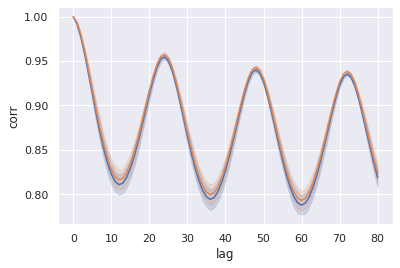

In [31]:
for ds in data[:2] :
    sns.lineplot(data=ds, x="lag", y="corr")

In [ ]:
for ds in data:
    sns.lineplot(data=ds, x="lag", y="corr")

In [ ]:
Coordinates = {
    'time':(['time'], week_2km.time.values[:5]),
    'rlon':(['rlon'], week_2km["rlon"].values[:3]),
    'rlat':(['rlat'], week_2km["rlat"].values[:3])
} 
x = np.arange(45).reshape((5,3,3));
x[1] = x[3]
x[3] = x[3] - np.array([[4,6,2],[3,5,7],[9,6,1]])
x[2] = x[2] + np.array([[-4,36,22],[43,-5,7],[2,-2,1]])
Variables = {
    'T_2M':(['time','rlat','rlon'], x)
}
test = xr.Dataset(Variables, Coordinates)
x2 = x
x2[0] = x2[1] + np.array([[4,5,2],[3,5,7],[9,-6,1]])
x2[4] = x2[4] - np.array([[-4,3,22],[43,-5,-7],[2,-2,1]])
Variables2 = {
    'T_2M':(['time','rlat','rlon'], x2)
}
test2 = xr.Dataset(Variables2, Coordinates)
test.T_2M.values

In [ ]:
lag_ds = [np.array([np.append(test.T_2M.values[i, j:, :], test.T_2M.values[i, :j, :]) for i in range(len(test.T_2M.values))]) for j in range(1, lag+1)]
lon_ds = np.array([test.T_2M.values[i, :, :].flatten() for i in range(len(test.T_2M.values))])
lag_ds

In [ ]:
lon_ds

In [ ]:
np.linspace(0,3,4)

In [ ]:
f_day = week_2km.isel(time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

In [ ]:
lag = 350
step = 1
df = metrics.corr(f_day, "rlon", lag, step)
sns.lineplot(data= df, x="lag", y="corr")

# Results

## Result form 0 to 1 

In [5]:
ds = results.get_results(week_2km, methods, ["bilinear", "bicubic", "quintic"])

In [24]:
ds = ds.replace(ds["Hellinger"].values, 1 - ds["Hellinger"].values) #I corrected that in the function, but didn't launched it again cause it's too long

In [27]:
ds_test

,method,RMSE,MAE,SSIM,Hellinger,Perkins
0,bilinear,0.244347,0.622488,0.544480,0.972325,0.976268
1,bicubic,0.239940,0.622338,0.554175,0.976417,0.979580
2,quintic,0.236445,0.619926,0.550467,0.976840,0.979792


In [26]:
ds_test.mean(axis=1)

/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0    0.671982
1    0.674490
2    0.672694
dtype: float64

We see with the two cells above that the results are uite similar for the 3 different "basic" methods. But on average, bicubic is the "best", followed by quintic and bilinear

## Some plots 

0

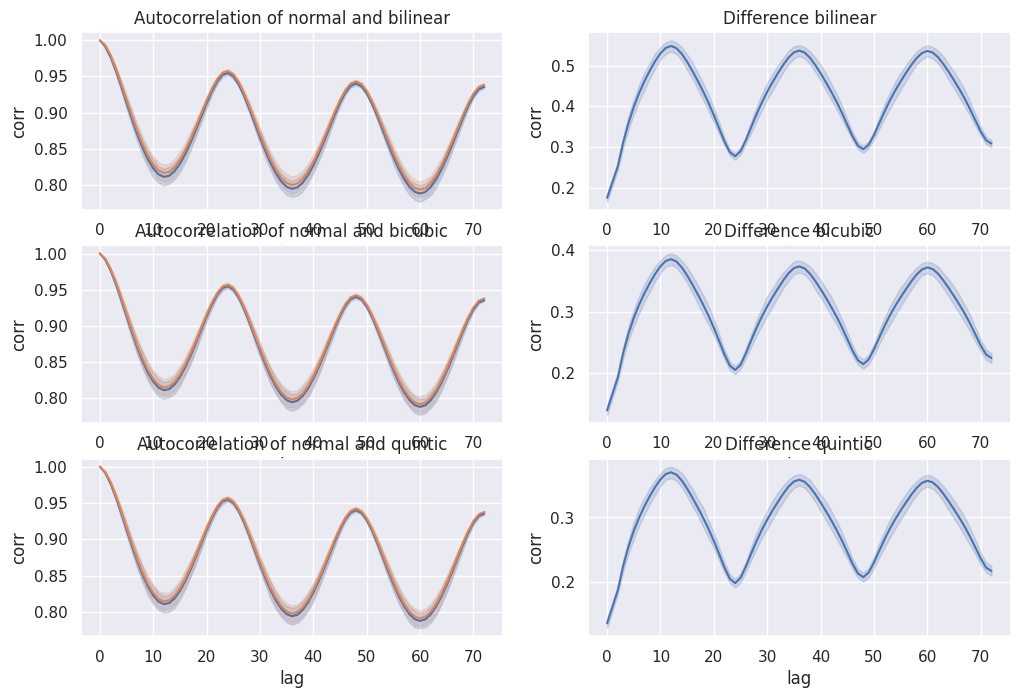

In [7]:
results.compare_corr(week_2km, methods, ["bilinear", "bicubic", "quintic"], "time", 72, 1)